In this notebook we conducted GWR and MGWR regression models on our data for the state of Oklahoma specifically.

The models are identical in variables, the only difference is the regression type. Both models utilize the accessibility score of each census tract within Oklahoma as the dependent variable. Meanwhile the independent variables are the percent white population, median household income, and percent with a bachelors degree or higher in each respective census tract.

The results from this model are quite impactful, yet the limitations from UChicago utilizing inefficient servers for programming make the results of the MGWR model in particular largely innaccessible. For better visualization of the output of this data, please refer to our poster and/or presentations, since these are the results accessible through software UChicago has chosen not to provide its research assistants, ArcPro.

In [2]:
import geopandas as gpd
import pandas as pd
#read in for plots
import pyarrow.parquet as pq
#to read vision Providers
import geodatasets
import folium
import numpy as np
pd.set_option('display.max_columns', None)

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pylab import rcParams
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

In [4]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

In [5]:
import plotly.express as px
import plotly.graph_objects as go

In [6]:
import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen

/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/opt/tljh/user/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:199: N

In [7]:
import esda
from esda.moran import Moran, Moran_Local

In [8]:
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights

In [9]:
from giddy.directional import Rose

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [11]:
from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error 

In [12]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

In [13]:
import warnings
warnings.filterwarnings('ignore') 
import time

In [14]:
#Read in census tract Info and boundaries
shape = gpd.read_file("../Geospatial/OK Tracts Collect.zip")

In [15]:
shape

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,40,027,201603,40027201603,2016.03,Census Tract 2016.03,G5020,S,1802253,0,+35.3411302,-097.4988890,"POLYGON ((-97.50602 35.34883, -97.50541 35.348..."
1,40,109,101500,40109101500,1015,Census Tract 1015,G5020,S,1839331,0,+35.4878699,-097.5038893,"POLYGON ((-97.51238 35.49325, -97.51237 35.493..."
2,40,037,021600,40037021600,216,Census Tract 216,G5020,S,11381986,53666,+35.9832820,-096.0808797,"POLYGON ((-96.11370 35.98849, -96.11235 35.988..."
3,40,037,021000,40037021000,210,Census Tract 210,G5020,S,122777173,1481235,+35.8142891,-096.3671181,"POLYGON ((-96.45864 35.76440, -96.45864 35.765..."
4,40,125,500700,40125500700,5007,Census Tract 5007,G5020,S,5212258,0,+35.3690103,-096.9297628,"POLYGON ((-96.94751 35.36282, -96.94751 35.363..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,40,061,279100,40061279100,2791,Census Tract 2791,G5020,S,212224575,63206595,+35.2877536,-094.8839111,"POLYGON ((-95.02176 35.29515, -95.02173 35.295..."
1201,40,033,871100,40033871100,8711,Census Tract 8711,G5020,S,794394066,7750653,+34.3799676,-098.3745316,"POLYGON ((-98.66198 34.33952, -98.66195 34.346..."
1202,40,033,871200,40033871200,8712,Census Tract 8712,G5020,S,844133096,16231596,+34.2050522,-098.3696386,"POLYGON ((-98.61006 34.16434, -98.61004 34.164..."
1203,40,131,050105,40131050105,501.05,Census Tract 501.05,G5020,S,20780698,0,+36.3086263,-095.6492480,"POLYGON ((-95.66866 36.29378, -95.66865 36.294..."


In [16]:
#Read in coverage score information for each census tract in IL
coverage = pd.read_csv("../OK Work/OKtracts_coveragescore.csv")

In [17]:
coverage

,Unnamed: 0,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Score,Areas,TotalPop,WhitePerc,Median_household_income,Mean_household_income,Bach_or_higher_perc,No_high_school_grad_perc,Percent_insured
0,1136,40,1,376600,40001376600,3766.0,Census Tract 3766,G5020,S,205931994,2861371,36.111948,-94.658801,0.194633,2.087934e+08,2331,57.06,35814,53186,9.3,15.0,76.0
1,1135,40,1,376700,40001376700,3767.0,Census Tract 3767,G5020,S,361464360,1471059,36.009308,-94.662345,0.022552,3.629354e+08,4654,50.52,44746,52684,7.4,15.1,76.3
2,1138,40,1,376800,40001376800,3768.0,Census Tract 3768,G5020,S,476998539,3114628,35.802166,-94.731542,0.321125,4.801132e+08,3848,35.03,44732,59727,14.5,17.3,74.3
3,1134,40,1,376900,40001376900,3769.0,Census Tract 3769,G5020,S,39833657,231548,35.811720,-94.639342,2.000000,4.006521e+07,4305,28.18,27524,36742,11.1,28.4,76.6
4,1137,40,1,377000,40001377000,3770.0,Census Tract 3770,G5020,S,402109229,1194105,35.764728,-94.574950,0.433162,4.033033e+08,4357,32.20,38914,51809,10.7,19.2,71.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,27,40,153,953100,40153953100,9531.0,Census Tract 9531,G5020,S,1413767859,2457482,36.498409,-99.147723,0.062989,1.416225e+09,2059,87.32,70066,88132,29.1,5.3,85.6
1201,26,40,153,953200,40153953200,9532.0,Census Tract 9532,G5020,S,1704564495,7086032,36.341915,-99.382088,0.471164,1.711651e+09,4867,79.72,78897,84106,14.8,13.6,87.4
1202,30,40,153,953300,40153953300,9533.0,Census Tract 9533,G5020,S,36724914,43636,36.412379,-99.367295,5.000000,3.676856e+07,4114,73.75,54090,72685,15.9,14.2,79.0
1203,28,40,153,953400,40153953400,9534.0,Census Tract 9534,G5020,S,27792536,0,36.452991,-99.447187,3.647172,2.779254e+07,3426,74.49,56398,69293,18.3,22.1,79.3


In [18]:
#set geoID as int
shape['GEOID']=shape['GEOID'].astype(int)

In [19]:
#set geoID as int
coverage['GEOID']=coverage['GEOID'].astype(int)

In [20]:
#merged coverage and census tract geometries
mergedTract=pd.merge(shape, coverage, how='inner', on= "GEOID")
mergedTract

,STATEFP_x,COUNTYFP_x,TRACTCE_x,GEOID,NAME_x,NAMELSAD_x,MTFCC_x,FUNCSTAT_x,ALAND_x,AWATER_x,INTPTLAT_x,INTPTLON_x,geometry,Unnamed: 0,STATEFP_y,COUNTYFP_y,TRACTCE_y,NAME_y,NAMELSAD_y,MTFCC_y,FUNCSTAT_y,ALAND_y,AWATER_y,INTPTLAT_y,INTPTLON_y,Score,Areas,TotalPop,WhitePerc,Median_household_income,Mean_household_income,Bach_or_higher_perc,No_high_school_grad_perc,Percent_insured
0,40,027,201603,40027201603,2016.03,Census Tract 2016.03,G5020,S,1802253,0,+35.3411302,-097.4988890,"POLYGON ((-97.50602 35.34883, -97.50541 35.348...",0,40,27,201603,2016.03,Census Tract 2016.03,G5020,S,1802253,0,35.341130,-97.498889,69.077245,1.802255e+06,3845,67.02,50216,55895,18.3,12.5,75.9
1,40,109,101500,40109101500,1015,Census Tract 1015,G5020,S,1839331,0,+35.4878699,-097.5038893,"POLYGON ((-97.51238 35.49325, -97.51237 35.493...",1,40,109,101500,1015.00,Census Tract 1015,G5020,S,1839331,0,35.487870,-97.503889,102.564324,1.839333e+06,1912,36.82,46429,66184,42.7,4.1,88.1
2,40,037,021600,40037021600,216,Census Tract 216,G5020,S,11381986,53666,+35.9832820,-096.0808797,"POLYGON ((-96.11370 35.98849, -96.11235 35.988...",2,40,37,21600,216.00,Census Tract 216,G5020,S,11381986,53666,35.983282,-96.080880,16.424527,1.143565e+07,2674,73.41,50688,68490,24.9,8.9,85.8
3,40,037,021000,40037021000,210,Census Tract 210,G5020,S,122777173,1481235,+35.8142891,-096.3671181,"POLYGON ((-96.45864 35.76440, -96.45864 35.765...",3,40,37,21000,210.00,Census Tract 210,G5020,S,122777173,1481235,35.814289,-96.367118,1.316797,1.242584e+08,3681,66.31,31660,47621,9.6,12.5,83.0
4,40,125,500700,40125500700,5007,Census Tract 5007,G5020,S,5212258,0,+35.3690103,-096.9297628,"POLYGON ((-96.94751 35.36282, -96.94751 35.363...",4,40,125,500700,5007.00,Census Tract 5007,G5020,S,5212258,0,35.369010,-96.929763,9.575313,5.212258e+06,3645,59.97,50769,64645,26.1,7.4,93.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,40,061,279100,40061279100,2791,Census Tract 2791,G5020,S,212224575,63206595,+35.2877536,-094.8839111,"POLYGON ((-95.02176 35.29515, -95.02173 35.295...",1200,40,61,279100,2791.00,Census Tract 2791,G5020,S,212224575,63206595,35.287754,-94.883911,0.021391,2.754312e+08,1871,69.27,47222,59930,11.7,14.3,82.3
1201,40,033,871100,40033871100,8711,Census Tract 8711,G5020,S,794394066,7750653,+34.3799676,-098.3745316,"POLYGON ((-98.66198 34.33952, -98.66195 34.346...",1201,40,33,871100,8711.00,Census Tract 8711,G5020,S,794394066,7750653,34.379968,-98.374532,0.001030,8.021447e+08,3545,74.25,55500,75348,18.3,16.4,88.2
1202,40,033,871200,40033871200,8712,Census Tract 8712,G5020,S,844133096,16231596,+34.2050522,-098.3696386,"POLYGON ((-98.61006 34.16434, -98.61004 34.164...",1202,40,33,871200,8712.00,Census Tract 8712,G5020,S,844133096,16231596,34.205052,-98.369639,0.000000,8.603647e+08,1982,79.72,52188,69880,14.4,16.4,85.2
1203,40,131,050105,40131050105,501.05,Census Tract 501.05,G5020,S,20780698,0,+36.3086263,-095.6492480,"POLYGON ((-95.66866 36.29378, -95.66865 36.294...",1203,40,131,50105,501.05,Census Tract 501.05,G5020,S,20780698,0,36.308626,-95.649248,7.689288,2.078070e+07,5383,67.81,68932,89198,35.5,6.1,89.7


In [21]:
#Specify geometry
mergedTract = mergedTract.set_geometry(mergedTract["geometry"])

In [22]:
#Set Dependent variable
y = mergedTract['Score'].values.reshape((-1,1)) # reshape is needed to have column array

In [23]:
#Set independent variables
X = mergedTract[['Median_household_income', 'Bach_or_higher_perc', 'WhitePerc']].values
X.shape

(1205, 3)

In [24]:
#Set coordinates
u = mergedTract['INTPTLON_y']
v = mergedTract['INTPTLAT_y']
coords = list(zip(u,v))

In [25]:

%%time
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()

CPU times: user 20.5 s, sys: 1min, total: 1min 21s
Wall time: 7.35 s


In [26]:
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 50.0


In [27]:
#Run GWR regression model
gwr_results = GWR(coords, y, X, gwr_bw).fit()

In [28]:
#View results of GWR
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                1205
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                        1269732.908
Log-likelihood:                                                   -5903.271
AIC:                                                              11814.541
AICc:                                                             11816.591
BIC:                                                            1261212.732
R2:                                                                   0.381
Adj. R2:                                                              0.379

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [29]:
#View mean R2
print('Mean R2 =', gwr_results.R2)

Mean R2 = 0.9592900573887728


In [30]:
#View AICc
print('AICc =', gwr_results.aicc)

AICc = 9088.802296697024


In [31]:
#View AIC
print('AIC =', gwr_results.aic)

AIC = 8982.161936268536


In [32]:
#Set local R2 within DF
mergedTract['gwr_R2']=gwr_results.localR2

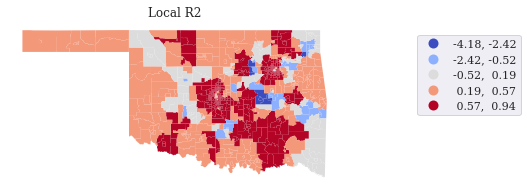

In [33]:
#Plot local R2 to assess model fit and variability
fig, ax = plt.subplots(figsize=(6, 6))
mergedTract.plot(column='gwr_R2', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.55, 0.96)},  ax=ax)
ax.set_title('Local R2', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [34]:
#Add GWR INT to DF
mergedTract['gwr_intercept'] = gwr_results.params[:,0]

In [35]:
#Add gwr fb to df
mergedTract['gwr_fb']        = gwr_results.params[:,1]

In [36]:
#Add gwr aa to df
mergedTract['gwr_aa']        = gwr_results.params[:,2]

In [37]:
#Add gwr rural to df
mergedTract['gwr_rural']     = gwr_results.params[:,3]

In [38]:
mergedTract

,STATEFP_x,COUNTYFP_x,TRACTCE_x,GEOID,NAME_x,NAMELSAD_x,MTFCC_x,FUNCSTAT_x,ALAND_x,AWATER_x,INTPTLAT_x,INTPTLON_x,geometry,Unnamed: 0,STATEFP_y,COUNTYFP_y,TRACTCE_y,NAME_y,NAMELSAD_y,MTFCC_y,FUNCSTAT_y,ALAND_y,AWATER_y,INTPTLAT_y,INTPTLON_y,Score,Areas,TotalPop,WhitePerc,Median_household_income,Mean_household_income,Bach_or_higher_perc,No_high_school_grad_perc,Percent_insured,gwr_R2,gwr_intercept,gwr_fb,gwr_aa,gwr_rural
0,40,027,201603,40027201603,2016.03,Census Tract 2016.03,G5020,S,1802253,0,+35.3411302,-097.4988890,"POLYGON ((-97.50602 35.34883, -97.50541 35.348...",0,40,27,201603,2016.03,Census Tract 2016.03,G5020,S,1802253,0,35.341130,-97.498889,69.077245,1.802255e+06,3845,67.02,50216,55895,18.3,12.5,75.9,0.674064,91.916079,-0.000219,-0.489882,-0.174349
1,40,109,101500,40109101500,1015,Census Tract 1015,G5020,S,1839331,0,+35.4878699,-097.5038893,"POLYGON ((-97.51238 35.49325, -97.51237 35.493...",1,40,109,101500,1015.00,Census Tract 1015,G5020,S,1839331,0,35.487870,-97.503889,102.564324,1.839333e+06,1912,36.82,46429,66184,42.7,4.1,88.1,0.515352,84.630365,-0.000015,0.119468,0.213520
2,40,037,021600,40037021600,216,Census Tract 216,G5020,S,11381986,53666,+35.9832820,-096.0808797,"POLYGON ((-96.11370 35.98849, -96.11235 35.988...",2,40,37,21600,216.00,Census Tract 216,G5020,S,11381986,53666,35.983282,-96.080880,16.424527,1.143565e+07,2674,73.41,50688,68490,24.9,8.9,85.8,0.837331,146.218136,-0.000877,2.299714,-1.632254
3,40,037,021000,40037021000,210,Census Tract 210,G5020,S,122777173,1481235,+35.8142891,-096.3671181,"POLYGON ((-96.45864 35.76440, -96.45864 35.765...",3,40,37,21000,210.00,Census Tract 210,G5020,S,122777173,1481235,35.814289,-96.367118,1.316797,1.242584e+08,3681,66.31,31660,47621,9.6,12.5,83.0,0.225291,14.473246,-0.000073,0.675113,-0.232369
4,40,125,500700,40125500700,5007,Census Tract 5007,G5020,S,5212258,0,+35.3690103,-096.9297628,"POLYGON ((-96.94751 35.36282, -96.94751 35.363...",4,40,125,500700,5007.00,Census Tract 5007,G5020,S,5212258,0,35.369010,-96.929763,9.575313,5.212258e+06,3645,59.97,50769,64645,26.1,7.4,93.5,0.599391,27.207978,-0.000025,0.286342,-0.377111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,40,061,279100,40061279100,2791,Census Tract 2791,G5020,S,212224575,63206595,+35.2877536,-094.8839111,"POLYGON ((-95.02176 35.29515, -95.02173 35.295...",1200,40,61,279100,2791.00,Census Tract 2791,G5020,S,212224575,63206595,35.287754,-94.883911,0.021391,2.754312e+08,1871,69.27,47222,59930,11.7,14.3,82.3,-1.335758,8.718805,-0.000057,0.062490,-0.093885
1201,40,033,871100,40033871100,8711,Census Tract 8711,G5020,S,794394066,7750653,+34.3799676,-098.3745316,"POLYGON ((-98.66198 34.33952, -98.66195 34.346...",1201,40,33,871100,8711.00,Census Tract 8711,G5020,S,794394066,7750653,34.379968,-98.374532,0.001030,8.021447e+08,3545,74.25,55500,75348,18.3,16.4,88.2,0.455236,37.780943,-0.000067,-0.012761,-0.369055
1202,40,033,871200,40033871200,8712,Census Tract 8712,G5020,S,844133096,16231596,+34.2050522,-098.3696386,"POLYGON ((-98.61006 34.16434, -98.61004 34.164...",1202,40,33,871200,8712.00,Census Tract 8712,G5020,S,844133096,16231596,34.205052,-98.369639,0.000000,8.603647e+08,1982,79.72,52188,69880,14.4,16.4,85.2,0.568109,38.277273,-0.000094,0.089048,-0.403237
1203,40,131,050105,40131050105,501.05,Census Tract 501.05,G5020,S,20780698,0,+36.3086263,-095.6492480,"POLYGON ((-95.66866 36.29378, -95.66865 36.294...",1203,40,131,50105,501.05,Census Tract 501.05,G5020,S,20780698,0,36.308626,-95.649248,7.689288,2.078070e+07,5383,67.81,68932,89198,35.5,6.1,89.7,-0.236865,43.349041,-0.000052,0.359480,-0.625515


In [39]:
# Filter t-values: standard alpha = 0.05
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)

In [40]:
# Filter t-values: corrected alpha due to multiple testing
gwr_filtered_tc = gwr_results.filter_tvals()

In [41]:
Zy = (y - y.mean(axis=0)) / y.std(axis=0)
ZX = (X - X.mean(axis=0)) / X.std(axis=0)

In [42]:
#Run mgwr model
mgwr_selector = Sel_BW(coords, Zy, ZX, multi=True)
mgwr_bw = mgwr_selector.search()
mgwr_bw

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

array([  44.,   44.,   44., 1203.])

In [ ]:
#View results of MGWR model
mgwr_results = MGWR(coords, Zy, ZX, mgwr_selector).fit()
mgwr_results.summary()